In [56]:
import pandas as pd, os, re, datetime as dt, scipy
from pathlib import Path
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from utils import *

# For testing purposes
checkup_required = False
if checkup_required:
    CHECKUP_FOLDER = Path('./Results/Checkup')
    Path.mkdir(CHECKUP_FOLDER, exist_ok=True, parents=True)

vaccine_shorts

{'Вакцина для профілактики поліомієліту (оральна)': 'ОПВ',
 'Вакцина для профілактики поліомієліту (інактивована)': 'ІПВ',
 'Вакцина для профілактики туберкульозу': 'БЦЖ',
 'Вакцина для профілактики кашлюку, дифтерії та правця з цільноклітинним кашлюковим компонентом': 'АКДП',
 'Вакцина для профілактики кору, паротиту та краснухи': 'КПК',
 'Вакцина для профілактики гепатиту В для дітей': 'ГепВ',
 'Вакцина для профілактики гепатиту В для дорослих': 'ГепВ-Дор',
 'Вакцина для профілактики правця': 'Правець',
 'Анатоксин для профілактики дифтерії та правця (АДП)': 'АДП',
 'Анатоксин для профілактики дифтерії та правцю з зменшеним вмістом антигену (АДП-М)': 'АДП-М',
 'Вакцина для профілактики гемофільної інфекції типу b': 'ХІБ',
 'Комбінована вакцина для профілактики кашлюка з цільноклітинним кашлюковим компонентом, дифтерії, правця, гепатиту В та гемофільної інфекції типу b': 'Пента',
 'Комбінована вакцина для профілактики дифтерії, правця, коклюшу, гемофільної інфекції та поліомієліту': '

In [57]:
LATEST_FILE = sorted([filename for filename in DATA_FOLDER.iterdir() if filename.stem not in ['.DS_Store', 'Auxillary', 'Historical Data']], key=lambda fn: dt.date.fromisoformat(fn.name[-5 - 10:-5]))[-1]
LATEST_FILE.name

'ВСЬОГО – 2024-02-23.xlsx'

In [62]:
# sheet_id = "1koUddJooo_5mQAssJKISCSXJGEIhIxfrWGRpzwYIZ1o"
# sheet_name = "Всього"
# url = f"https://docs.google.com/spreadsheets/d/1koUddJooo_5mQAssJKISCSXJGEIhIxfrWGRpzwYIZ1o/edit#gid=1511936617"
# dfs = []

sorted_files = sorted([filename for filename in DATA_FOLDER.iterdir() if filename.stem not in ['.DS_Store', 'Auxillary', 'Historical Data']], key=lambda fn: dt.date.fromisoformat(fn.name[-5 - 10:-5]))

LATEST_FILE = sorted_files[-1]


for filepath in sorted_files:
    if filepath.name.startswith('~') or '.DS_Store' in filepath.name:
        continue

    if filepath == LATEST_FILE:
        pattern = r'(\d{4})-(\d{2})-(\d{2})'
        date_match = re.search(pattern, filepath.name)

        if date_match:
            year = date_match.group(1)
            month = date_match.group(2)
            day = date_match.group(3)

        df = pd.read_excel(filepath, sheet_name='Залишки поточні', dtype={' код ЄДРПОУ': str}, engine='openpyxl')
        df.columns = df.columns.str.strip()
        df.rename(columns={'Серія препарту': 'Серія препарату'}, inplace=True)

        # ————————————————————————————————————————————————————— Temporary Middleware Section —————————————————————————————————————————————————————
        # df['код ЄДРПОУ'] = df['код ЄДРПОУ'].astype(int, errors='ignore')
        df['Заклад'] = df['Заклад'].str.strip()
        df['Кількість доз'] = df['Кількість доз'].astype(int)
        df['Регіон'] = df['Регіон'].str.replace(' область', '')
        df['Регіон'] = df['Регіон'].str.replace(' обл.', '')
        df['Регіон'] = df['Регіон'].str.replace(' обл', '')
        
        # df['дата оновлення'].replace(dt.datetime(203, 12, 7, 0, 0), dt.datetime(2023, 12, 7, 0, 0), inplace=True)
        df = df[df["Міжнародна непатентована назва"].notna()]
        df['Регіон'] = df['Регіон'].replace('чЕРНІГІВСЬКА ОБЛАСТЬ', 'Чернігівська область')
        df['Джерело фінансування'] = df['Джерело фінансування'].fillna('Невідоме джерело')
        df['Джерело фінансування'] = df['Джерело фінансування'].replace(['Держбюджет', 'Державний бюджет'], 'Державний бюджет (невідомий рік)')
        df['Термін придатності'] = df['Термін придатності'].replace(dt.datetime(206,8,31), dt.datetime(2026, 8, 31))
        # ————————————————————————————————————————————————————— Temporary Middleware Section —————————————————————————————————————————————————————
        

# ———————————————————————————— Визначити назву вакцини за серією препарату і переписати назви у вхідних даних ————————————————————————————
series_df = df.groupby(['Серія препарату'])['Міжнародна непатентована назва'].apply(lambda vaccines: [[vaccine, len(vaccines[vaccines==vaccine])] for vaccine in vaccines.unique() if not pd.isna(vaccine)]).reset_index()

# Вивести серії без жодної назви препарату
series_df[series_df['Міжнародна непатентована назва'].apply(lambda vaccines: len(vaccines))==0].to_excel(RESULTS_FOLDER / 'Серії без назв препаратів.xlsx', index=False)
# Вивести серії з багатьма варіантами назв препаратів
series_df[series_df['Міжнародна непатентована назва'].apply(lambda vaccines: len(vaccines))>1].to_excel(RESULTS_FOLDER / 'Серії з багатьма варіантами назв препаратів.xlsx', index=False)

# Залишити тільки серії, де є хоча б одна назва препарату
series_df = series_df[~(series_df['Міжнародна непатентована назва'].apply(lambda vaccines: len(vaccines))==0)]

# Обрати назву препарату, яка найчастіше зустрічається в серії
overwritings = series_df.apply(lambda row: max(row['Міжнародна непатентована назва'], key=lambda pair: pair[1])[0], axis=1)
series_df['Назва препарату'] = overwritings

series_df = series_df[['Серія препарату', 'Назва препарату']].set_index('Серія препарату')

df['Міжнародна непатентована назва'] = df[['Серія препарату', 'Міжнародна непатентована назва']].apply(lambda row: series_df.to_dict()['Назва препарату'].get(row['Серія препарату'], row['Міжнародна непатентована назва']), axis=1)
# ————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

# ——————————————————————————––—— Визначити назву закладу за кодом ЄДРПОУ і переписати назви у вхідних даних ————––————————————————————————
multiple_names_edrpou = df.groupby(['код ЄДРПОУ'])['Заклад'].apply(lambda facilities: [[facility, len(facilities[facilities==facility])] for facility in facilities.unique() if not pd.isna(facility)]).reset_index()

# Вивести серії без жодної назви препарату
multiple_names_edrpou[multiple_names_edrpou['Заклад'].apply(lambda facilities: len(facilities))==0].to_excel(RESULTS_FOLDER / 'Коди ЄДРПОУ без назв закладів.xlsx', index=False)
# Вивести серії з багатьма варіантами назв препаратів
multiple_names_edrpou[multiple_names_edrpou['Заклад'].apply(lambda facilities: len(facilities))>1].to_excel(RESULTS_FOLDER / 'Коди ЄДРПОУ з багатьма варіантами назв закладів.xlsx', index=False)

multiple_names_edrpou = multiple_names_edrpou[multiple_names_edrpou['Заклад'].apply(lambda facilities: len(facilities))>1]
overwritings = multiple_names_edrpou.apply(lambda row: max(row['Заклад'], key=lambda pair: pair[1])[0], axis=1)
multiple_names_edrpou['Назва закладу'] = overwritings
multiple_names_edrpou = multiple_names_edrpou[['код ЄДРПОУ', 'Назва закладу']].set_index('код ЄДРПОУ')
df['Заклад'] = df[['код ЄДРПОУ', 'Заклад']].apply(lambda row: multiple_names_edrpou.to_dict()['Назва закладу'].get(row['код ЄДРПОУ'], row['Заклад']), axis=1)
# ————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————

vaccines = sorted(df['Міжнародна непатентована назва'].dropna().unique())

df['Міжнародна непатентована назва'] = df['Міжнародна непатентована назва'].replace(vaccine_shorts)
df = df[~df['Міжнародна непатентована назва'].isin(['Правець', 'ДПКГП', 'ГепВ-Дор'])]

df['Термін придатності'] = pd.to_datetime(df['Термін придатності']).dt.date
df['дата оновлення'] = pd.to_datetime(df['дата оновлення']).dt.date

df = df[df['Термін придатності'] >= df['дата оновлення']]


# Remove any data reporting vaccine with expiration date older than the newest report date (to simplify the analysis)
REPORT_DATE = df['дата оновлення'].max()
timed_outs = df[(REPORT_DATE - df['дата оновлення']) > dt.timedelta(days=7)]
df[df['Термін придатності'] < REPORT_DATE]

# Add national leftovers data
national_leftovers_df = pd.read_excel(DATA_FOLDER/'Auxillary'/'Залишки нацрівня.xlsx', sheet_name='14.02.2024')
national_leftovers_df.rename(columns={'Вакцина': 'Міжнародна непатентована назва', 'Залишок': 'Кількість доз'}, inplace=True)
national_leftovers_df['Регіон'] = 'Україна'
national_leftovers_df['Термін придатності'] = national_leftovers_df['Термін придатності'].dt.date 
df = pd.concat([df, national_leftovers_df], ignore_index=True)

# Save preprocessed data
Path.mkdir(DATA_FOLDER / 'Historical Data', exist_ok=True, parents=True)
if not Path.exists(DATA_FOLDER / 'Historical Data' / f'{year}-{month}-{day}.pkl'):
    df.to_pickle(DATA_FOLDER / 'Historical Data' / f'{year}-{month}-{day}.pkl')

# Create a set of different diseases we have vaccines for
# diseases_set = set(disease_vaccine_dict.keys())

df

/var/folders/gc/9t_hywd97l7fb1yjstm49l1w0000gn/T/ipykernel_68813/2154518466.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Термін придатності'] = df['Термін придатності'].replace(dt.datetime(206,8,31), dt.datetime(2026, 8, 31))


,код ЄДРПОУ,Заклад,Серія препарату,Міжнародна непатентована назва,Торгівельна назва,Виробник,Термін придатності,Джерело фінансування,Кількість доз,дата оновлення,Регіон,Коментар
0,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",1141M019A,ХІБ,ВАКЦИНА КОН`ЮГОВАНА ДЛЯ ПРОФІЛАКТИКИ ЗАХВОРЮВА...,"СЕРУМ ІНСТИТУТ ІНДІЇ ПВТ. ЛТД., Індія",2024-05-21,Державний бюджет 2021,54,2024-02-23,Вінницька,NaN
1,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",X007788,КПК,"MMRVAXPRO II 0,5ML 10X1DOSE VIAL L25","Merck & Co., Inc.",2024-05-26,Гуманітарна допомога,6,2024-02-23,Вінницька,NaN
2,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",D2708,АДП-М,"ТЕТАДІФ суспензія для ін'єкцій 0,5 мл (1 доза)...",ББ-НЦІПХЛтд. Болгарія,2025-11-30,Державний бюджет 2021,113,2024-02-23,Вінницька,NaN
3,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",2249001B,ІПВ,Inactivated Poliomyelitis Vaccine,Bilthoven Biologicals B.V.,2025-12-08,Гуманітарна допомога,13,2024-02-23,Вінницька,NaN
4,35527334,"КНП ""ЦПМСД №1"" м. Вінниця",62С22009А,Сказ,"ІНДІРАБ ВАКЦИНА АНТИРАБІЧНА ОЧИЩЕНА, ІНАКТИВОВ...","ТОВ ""Фарма Лайф"", Україна",2025-10-31,Державний бюджет 2021,7,2024-02-23,Вінницька,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17999,NaN,NaN,NaN,Пента,NaN,NaN,2026-01-31,Державний бюджет 2023,64500,NaN,Україна,УВ
18000,NaN,NaN,NaN,АКДП,NaN,NaN,2025-05-31,Гуманітарна допомога,98280,NaN,Україна,ФС
18001,NaN,NaN,NaN,ІПВ,NaN,NaN,2026-05-30,Гуманітарна допомога,101880,NaN,Україна,ФС
18002,NaN,NaN,NaN,АДП-М,NaN,NaN,2026-08-31,Державний бюджет 2023,237100,NaN,Україна,МЗУ


#### Клітинки для тестів

In [63]:
# df[ (df['Заклад'].isna()) | (df['Заклад'].str.strip() == '') ]
# df[ (df['Регіон'] == 'Закарпатська область') & (df['Міжнародна непатентована назва'] == 'Комбінована вакцина для профілактики дифтерії, правця, коклюшу, гемофільної інфекції та поліомієліту') ]
REPORT_DATE

datetime.date(2024, 2, 23)

In [64]:
df['Виробник'].unique().__len__()


50

## Create an HTML report with all Leftovers included

### Regional Part

In [65]:
region_with_foundsource_df = df.groupby(['Регіон', "Міжнародна непатентована назва", 'Джерело фінансування'])['Кількість доз'].sum().reset_index()
region_with_foundsource_df

,Регіон,Міжнародна непатентована назва,Джерело фінансування,Кількість доз
0,Івано-Франківська,ІПВ,Гуманітарна допомога,12157
1,Івано-Франківська,АДП,Гуманітарна допомога,19
2,Івано-Франківська,АДП,Державний бюджет 2018,20
3,Івано-Франківська,АДП,Державний бюджет 2021,2968
4,Івано-Франківська,АДП-М,Гуманітарна допомога,6323
...,...,...,...,...
468,м. Київ,Сказ,Державний бюджет 2020,6
469,м. Київ,Сказ,Державний бюджет 2021,2175
470,м. Київ,ХІБ,Гуманітарна допомога,2950
471,м. Київ,ХІБ,Державний бюджет 2021,1698


In [66]:
region_df = df.groupby(["Регіон", "Міжнародна непатентована назва"])[['Кількість доз']].sum().reset_index()

region_df = region_df.pivot_table(values='Кількість доз', columns='Регіон', index='Міжнародна непатентована назва').fillna(0).astype(int).T

region_df.sort_index(key=lambda index: pd.Index(region_positions[x] for x in index), inplace=True)
region_df

Міжнародна непатентована назва,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
Регіон,,,,,,,,,,,
Вінницька,8255,5920,13262,23927,11625,14309,11624,21409,4409,5742,3215
Волинська,7010,2710,6713,18283,8500,17051,5001,14228,4932,927,1126
Дніпропетровська,14952,11131,13625,43191,9240,18299,11389,30700,8376,1191,11377
Донецька,2399,847,484,2533,3570,3190,1277,3833,1592,1551,804
Житомирська,10152,5198,8062,18233,11390,14115,6447,10674,4859,4318,3111
Закарпатська,10032,6462,12774,15562,8330,17383,6828,16623,4157,1061,5025
Запорізька,3009,2628,3737,5781,2280,4829,2378,6552,2496,998,1807
Івано-Франківська,12157,3007,14100,23286,9100,11554,10186,13073,3034,1419,1111
Київська,12187,6329,55104,37056,16000,17428,14114,18366,3974,2676,6949


In [67]:
if checkup_required:
    region_df.to_excel(CHECKUP_FOLDER / f'Залишки по регіонах на {REPORT_DATE}.xlsx')

In [68]:
vaccines_left_sorted = region_df.sum(axis=0).sort_values(ascending=False).to_frame()
vaccines_left_sorted

,0
Міжнародна непатентована назва,
АДП-М,1431360
АКДП,599691
ОПВ,338266
КПК,312709
ГепВ,311685
ІПВ,290289
БЦЖ,259019
Пента,167967
АДП,101484


#### Протерміновані звіти про вакцини

In [69]:
# timed_out_reports = timed_outs.groupby('Регіон')[['Кількість доз', 'Заклад']].apply(lambda group: [group['Кількість доз'].sum(), len(group['Заклад'].unique())]).sort_values(ascending=False)
timed_out_reports = timed_outs.groupby('Регіон')[['Кількість доз', 'Заклад']].apply(lambda group: [group['Кількість доз'].sum(), group['Заклад'].unique()]).sort_values(ascending=False)

unknown_vaccine_leftovers_html = f"""
<div class="level-item has-text-centered">
    <div>
        <p class="heading mb-3">Залишки, прозвітовані більше, ніж 7 днів тому</p>
        <p class="title has-text-light">{int(timed_outs['Кількість доз'].sum()):,}</p>
    </div>
</div>
"""

timed_out_reports
timed_out_reports.to_json(orient='split', force_ascii=False),

('{"name":null,"index":["Івано-Франківська","Чернігівська"],"data":[[102027,["ДУ Івано-Франківський ОЦКПХ","КНП \\"Івано-Франківська обласна дитяча клінічна лікарня ІФ ОР\\"","ФОП Кабан В.Б.","ФОП Костирко Н.І.","ТзОВ \\"Нейро Глобал\\"","ФОП Пілецька Л.І.","ТОВ \\"Вест МЕДІКАЛ\\"","ТОВ \\"Приватна дитяча поліклініка №1\\"","ФОП \\"Бенько Г.С.\\"","ЛДЦ \\"Святого ЛУКИ\\"","ТзОВ \\"Медекс ППЮЛ\\"","ТОВ \\"Комфорт-здоров\'я\'\\"","\\"Оксфорд Медікал\\"","ФОП Венгринович В.В.","ФОП Білик Роман Павлович","ФОП ФЕДОРИН І Я","КНП \\"БОГОРОДЧАНСЬКА ЦЕНТРАЛЬНА ЛІКАРНЯ\\" БОГОРОДЧАНСЬКОЇ СЕЛИЩНОЇ РАДИ","КНП \\"ЛИСЕЦЬКА ЛІКАРНЯ\\" ЛИСЕЦЬКОЇ СЕЛИЩНОЇ РАДИ ІВАНО-ФРАНКІВСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВСЬКОЇ ОБЛАСТІ","КНП\'\'Тисменицька міська лікарня\\"Тисменицької міської ради","КНП \\"ЄЗУПІЛЬСЬКА МІСЬКА ЛІКАРНЯ\\" ЄЗУПІЛЬСЬКОЇ СЕЛИЩНОЇ РАДИ ІВАНО-ФРАНКІВСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВСЬКОЇ ОБЛАСТІ","КНП \\"ЦПМСД\\" Ямницької сільської ради","КНП \\"ДЗВИНЯЦЬКИЙ ЦЕНТР ПЕРВИННОЇ МЕДИКО-САНІТАРНОЇ ДОПОМОГИ\\" 

#### Дефіцитні вакцини

In [70]:
regions_to_watch_html = """
<div class="level-item full-width">
    <div class="columns is-multiline is-centered">
        <div class="column is-full has-text-centered">
            <p class="title is-4 has-text-light">
                Дефіцитні вакцини:
            </p>
        </div>
"""
temp_region_df = region_df

region_df = region_df.loc[region_df.index!="Україна"].copy()

regions_and_vaccine_to_watch = []
for column in region_df.columns:
    if column == 'Україна':
        continue
    vaccine_threshold = region_df.sum(axis=0)/len(region_df.columns)/5
    presence_count = (region_df[column] > vaccine_threshold[column]).sum()
    absence_count = (region_df[column] <= vaccine_threshold[column]).sum()

    if presence_count > 16 and absence_count > 0:
        regions_without_vaccine = region_df[
            region_df[column] <= vaccine_threshold[column]
        ].index.tolist()
            
        regions_to_watch_html += f"""
        <div class="column is-4 has-text-centered">
            <div>
                <p class="title is-5 has-text-light mb-5">{column}</p>
                <p class="heading is-5 has-text-light">{', '.join(regions_without_vaccine)}</p>
            </div>
        </div>
        """

regions_to_watch_html+="""</div>
</div>"""

region_df = temp_region_df

#### Знайти регіони, де немає вакцин проти всіх хвороб, а також хвороби, проти яких немає вакцин

In [71]:
# Step 1: Group the dataframe by regions and for each group, get the set of diseases that can be prevented by the vaccines available in the region
region_diseases = df[df['Кількість доз']>0].groupby('Регіон')['Міжнародна непатентована назва'].apply(
    lambda vaccines: set(disease for vaccine in set(vaccines) for disease, vaccine_list in disease_vaccine_dict.items() if vaccine in vaccine_list)
)
# Step 2: Compare the set of diseases for each region with the set of diseases from the dictionary
regions_without_all_diseases = region_diseases[region_diseases.apply(lambda x: not diseases_set.issubset(x))]

# Step 3: For each such region, find the diseases for which vaccines are missing
missing_diseases = regions_without_all_diseases.apply(lambda diseases: diseases_set - diseases)

missing_diseases_dict = missing_diseases.to_dict()
missing_diseases_dict

NameError: name 'disease_vaccine_dict' is not defined

### Institutional Part

#### Дані для радіальної діаграми: {Регіон -> Заклад -> Вакцина}

##### Актуальна версія

In [72]:
institutional_level_data_df = df.groupby(['Регіон', 'Заклад', 'Міжнародна непатентована назва'], dropna=False)[['Кількість доз']].sum().reset_index()
institutional_level_data_df.replace('Україна', 'НацСклади', inplace=True)

institutional_level_data_df['Заклад'] = institutional_level_data_df['Заклад'].fillna('Невідомий заклад')
institutional_level_data_df['Міжнародна непатентована назва'] = institutional_level_data_df['Міжнародна непатентована назва'].fillna('Невідома вакцина')
institutional_level_data_df.rename(columns={'Заклад': 'Fclt', 'Міжнародна непатентована назва': 'Name', 'Кількість доз': 'Amnt', 'Регіон':'Rgn'}, inplace=True)
# institutional_level_data_df.to_json('json.json', orient='records', force_ascii=False)
institutional_level_data_df['Name'].unique()

array(['АДП-М', 'Сказ', 'ІПВ', 'АДП', 'АКДП', 'БЦЖ', 'ГепВ', 'КПК', 'ОПВ',
       'Пента', 'ХІБ'], dtype=object)

##### Неактуальні версії

###### Регіон - Заклад – Вакцина

In [ ]:
institutionally_grouped_df = df.groupby(['Регіон', 'Заклад', 'Міжнародна непатентована назва'], dropna=False)[['Кількість доз']].sum().reset_index()

# Create a nested dictionary structure
institutions_result = []

for region, region_data in institutionally_grouped_df.groupby('Регіон'):
    region_entry = {'name': region, 'children': []}
    for institution, institution_data in region_data.groupby('Заклад', dropna=False):
        if (pd.isna(institution) or institution.strip() == ''): 
            institution = 'Невідомий заклад'
        institution_entry = {'name': institution, "value": float(institution_data['Кількість доз'].sum()), 'hidden_children': []}
        for _, row in institution_data.iterrows():
            vaccine_name = row['Міжнародна непатентована назва']
            if (pd.isna(vaccine_name) or vaccine_name.strip() == ''): 
                vaccine_name = 'Невідома вакцина'
            vaccine_entry = {'name': vaccine_name, 'value': row['Кількість доз']}
            institution_entry['hidden_children'].append(vaccine_entry)
        region_entry['children'].append(institution_entry)
    institutions_result.append(region_entry)


###### Вакцина – Регіон – Заклад

In [ ]:
institutionally_grouped_df = df.groupby(['Міжнародна непатентована назва', 'Регіон', 'Заклад'], dropna=False)[['Кількість доз']].sum().reset_index()

# Create a nested dictionary structure
institutions_result = []

for vaccine_name, vaccine_data in institutionally_grouped_df.groupby('Міжнародна непатентована назва', dropna=False):
    if (pd.isna(vaccine_name) or vaccine_name.strip() == ''): 
        vaccine_name = 'Невідома вакцина'
    vaccine_entry = {'name': vaccine_name, 'children': []}
    for region, region_data in vaccine_data.groupby('Регіон'):
        region_entry = {'name': region, "value": int(region_data['Кількість доз'].sum()), "hidden_children": []}
        for institution, institution_data in region_data.groupby('Заклад', dropna=False):
            if (pd.isna(institution) or institution.strip() == ''): 
                institution = 'Невідомий заклад'
            institution_entry = {'name': institution, "value": int(institution_data['Кількість доз'].sum())}
            region_entry['hidden_children'].append(institution_entry)
        vaccine_entry['children'].append(region_entry)
    institutions_result.append(vaccine_entry)

institutions_result

[{'name': 'ІПВ',
  'children': [{'name': 'Івано-Франківська',
    'value': 12765,
    'hidden_children': [{'name': 'ДУ Івано-Франківський ОЦКПХ', 'value': 9323},
     {'name': 'Здорова малеча ФОП Савюк', 'value': 39},
     {'name': 'КНП " ЦЕНТР ПЕРВИННОЇ МЕДИКО-САНІТАРНОЇ ДОПОМОГИ НОВИЦЬКОЇ СІЛЬСЬКОЇ РАДИ"',
      'value': 50},
     {'name': 'КНП "CОЛОТВИНСЬКА ЛІКАРНЯ" СОЛОТВИНСЬКОЇ СЕЛИЩНОЇ РАДИ ІВАНО-ФРАНКІВСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВСЬКОЇ ОБЛАСТІ',
      'value': 9},
     {'name': 'КНП "ЄЗУПІЛЬСЬКА МІСЬКА ЛІКАРНЯ" ЄЗУПІЛЬСЬКОЇ СЕЛИЩНОЇ РАДИ ІВАНО-ФРАНКІВСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВСЬКОЇ ОБЛАСТІ',
      'value': 12},
     {'name': 'КНП "Івано-Франківська обласна дитяча клінічна лікарня ІФ ОР"',
      'value': 81},
     {'name': 'КНП "АЗПСМ Рожнівської сільської ради"', 'value': 37},
     {'name': 'КНП "БРОШНІВ-ОСАДСЬКА МІСЬКА ЛІКАРНЯ" БРОШНІВ-ОСАДСЬКОЇ СЕЛИЩНОЇ РАДИ КАЛУСЬКОГО РАЙОНУ ІВАНО-ФРАНКІВ',
      'value': 25},
     {'name': 'КНП "БУРШТИНСЬКИЙ МІСЬКИЙ ЦЕНТР ПЕРВИННОЇ МЕДИКО-СА

In [ ]:
institutionally_grouped_df[institutionally_grouped_df['Заклад'].isna() | institutionally_grouped_df['Міжнародна непатентована назва'].isna()]


,Міжнародна непатентована назва,Регіон,Заклад,Кількість доз
998,ІПВ,Україна,NaN,156960
1149,ІПВ,Хмельницька,NaN,62
3653,АДП-М,Хмельницька,NaN,21
4774,АКДП,Україна,NaN,98280
4914,АКДП,Хмельницька,NaN,56
7142,ГепВ,м. Київ,NaN,640
8226,КПК,Україна,NaN,143950
8566,КПК,м. Київ,NaN,70
10199,Пента,Україна,NaN,64500
10291,Пента,Хмельницька,NaN,11


#### Кількість закладів, які подають звітність

In [ ]:
institution_df = df[['Регіон', 'код ЄДРПОУ', 'Заклад', 'Міжнародна непатентована назва', 'Кількість доз']].groupby(
    ['Регіон', 'код ЄДРПОУ', 'Заклад', 'Міжнародна непатентована назва']).sum().reset_index()
institution_df_usreou_only = institution_df.groupby(
    'код ЄДРПОУ')['Кількість доз'].sum().reset_index()


reporting_facilities_count_html = f"""<div class="column is-3 has-text-centered">
    <div>
        <p class="heading has-text-light">
            Кількість закладів, що звітують:
        </p>
        <p class="title is-4 has-text-light">
            {len(institution_df_usreou_only.index.unique())}
        </p>
    </div>
</div>
"""

#### 30% закладів з найменшою забезпеченістю вакцинами

In [ ]:
institution_df_usreou_only[institution_df_usreou_only['Кількість доз']<=institution_df_usreou_only['Кількість доз'].quantile(0.3)]

,код ЄДРПОУ,Кількість доз
1,1111032,60
2,1111121,54
3,1111227,17
4,1111233,25
5,1111598,96
...,...,...
1750,5498677,88
1751,5498683,68
1753,5498708,100
1756,5503562,23


#### Усі заклади, де є топ вакцини

In [ ]:
# Using vaccines list select only those facilities that have all the vaccines in the list
# Select the top-7 vaccines in the df dataframe
top_vaccines = df.groupby('Міжнародна непатентована назва')['Кількість доз'].sum().sort_values(ascending=False).head(7).index.tolist()

# Step 1: Create a set from the list of vaccines
vaccines_set = set(top_vaccines)

# Step 2: Group the dataframe by facilities and for each group, create a set of vaccines
facility_vaccines = institution_df.groupby('Заклад')['Міжнародна непатентована назва'].apply(set)

# Step 3: Compare the set of vaccines for each facility with the set of vaccines from the list
facilities_with_all_vaccines = facility_vaccines[facility_vaccines.apply(
    lambda present_vaccines: vaccines_set.issubset(present_vaccines)
)].index

# # Select only those facilities from the dataframe
r_df = institution_df[institution_df['Заклад'].isin(facilities_with_all_vaccines)]

all_vaccines_supplied_facilities_html = f"""<div class="column is-3 has-text-centered">
    <div>
        <p class="heading has-text-light">
            Кількість закладів, які мають усі 7 найбільш поширених вакцин:
        </p>
        <p class="title is-4 has-text-light">
            {len(facilities_with_all_vaccines.unique())}
        </p>
    </div>
</div>
"""

#### Усі заклади, де є вакцини проти всіх хвороб

In [ ]:
# Step 2: For each facility, get the set of diseases that can be prevented by the vaccines available in the facility
facility_diseases = institution_df.groupby('Заклад')['Міжнародна непатентована назва'].apply(
    lambda vaccines: set(disease for vaccine in vaccines for disease, vaccine_list in disease_vaccine_dict.items() if vaccine in vaccine_list)
)

# Step 3: Compare the set of diseases for each facility with the set of diseases from the dictionary
facilities_with_all_diseases = facility_diseases[facility_diseases.apply(lambda x: diseases_set.issubset(x))].index

# Select only those facilities from the dataframe
r_df = institution_df[institution_df['Заклад'].isin(facilities_with_all_diseases)]

all_diseases_supplied_facilities_html = f"""<div class="column is-3 has-text-centered">
    <div>
        <p class="heading has-text-light">
            Кількість закладів, які вакцинують проти всіх хвороб:
        </p>
        <p class="title is-4 has-text-light">
            {len(facilities_with_all_diseases.unique())}
        </p>
    </div>
</div>
"""

r_df['Регіон'].unique()

NameError: name 'disease_vaccine_dict' is not defined

### LeftoversUsageExpiration part

In [73]:
# For each region and each vaccine in it, build a dataframe with timeline of doses left
# The timeline will be displayed on the x axis, the number of doses on the y axis
# We need to calculate, how many doses will be left in the region after each day based on the
# 'Термін придатності' column, which contains the expiration date for each batch of vaccines
# Result structure is:
# {Region: pd.DataFrame(index is the timeline, columns are the vaccines, values are the doses left)}
expiration_timelines = {}
for region, region_data in df.groupby('Регіон'):
    regional_expirations = pd.DataFrame()
    for vaccine, vaccine_data in region_data.groupby('Міжнародна непатентована назва'):
        # vaccine_data['Термін придатності'] = pd.to_datetime(vaccine_data['Термін придатності']).dt.date
        vaccine_data = vaccine_data.groupby('Термін придатності')[['Кількість доз']].sum()
        # vaccine_data = vaccine_data.sort_index(ascending=True)
        vaccine_data.rename(columns={'Кількість доз': vaccine}, inplace=True)
        regional_expirations = pd.concat([regional_expirations, vaccine_data], axis=1)
        # regional_expirations = regional_expirations.groupby(regional_expirations.index).sum()
        regional_expirations.fillna(0, inplace=True)
        regional_expirations.sort_index(inplace=True)
    # regional_expirations.index = regional_expirations.index.astype(str)
    # region_vaccine_timeline[region] = regional_expirations.cumsum(axis=0)
    expiration_timelines[region] = regional_expirations

# Separately for Ukraine as a whole
regional_expirations = pd.DataFrame()
for vaccine, vaccine_data in df.groupby('Міжнародна непатентована назва'):
    # vaccine_data['Термін придатності'] = pd.to_datetime(vaccine_data['Термін придатності']).dt.date
    vaccine_data = vaccine_data.groupby('Термін придатності')[['Кількість доз']].sum()
    # vaccine_data = vaccine_data.sort_index(ascending=True)
    vaccine_data.rename(columns={'Кількість доз': vaccine}, inplace=True)
    regional_expirations = pd.concat([regional_expirations, vaccine_data], axis=1)
    # regional_expirations = regional_expirations.groupby(regional_expirations.index).sum()
    regional_expirations.fillna(0, inplace=True)
    regional_expirations.sort_index(inplace=True)
# regional_expirations.index = regional_expirations.index.astype(str)
# region_vaccine_timeline[region] = regional_expirations.cumsum(axis=0)
expiration_timelines["Україна"] = regional_expirations
# region_vaccine_timeline = {region: (region_df.T[region] - region_vaccine_timeline[region]).dropna(axis=1, how='all') for region in region_vaccine_timeline}

In [74]:
if checkup_required:
    Path.mkdir(CHECKUP_FOLDER/'Псування за терміном придатності', exist_ok=True, parents=True)
    for region in expiration_timelines:
        expiration_timelines[region].to_excel(CHECKUP_FOLDER/'Псування за терміном придатності' / f'{region}.xlsx')

In [75]:
expiration_timelines['Україна']

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
Термін придатності,,,,,,,,,,,
2024-02-17,0.0,0.0,0.0,0.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0
2024-02-28,0.0,0.0,0.0,0.0,1920.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-29,0.0,803.0,0.0,0.0,1060.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,274.0,0.0,0.0,0.0
2024-03-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30859.0,0.0,0.0,0.0
2024-03-31,0.0,0.0,0.0,0.0,0.0,81.0,2122.0,0.0,0.0,0.0,0.0
2024-04-01,0.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-30,0.0,3030.0,0.0,0.0,0.0,0.0,1300.0,0.0,0.0,0.0,0.0
2024-05-09,0.0,0.0,0.0,0.0,0.0,1301.0,0.0,0.0,0.0,0.0,0.0


In [76]:
df[ (df['Регіон']=='Дніпропетровська') 
   & (df['Міжнародна непатентована назва']=='АКДП') 
#    & (df['Термін придатності'].isna())
].groupby(["Термін придатності", ])["Кількість доз"].sum()

Термін придатності
2024-12-30      743
2025-01-31       37
2025-05-30    25680
2025-05-31    16731
Name: Кількість доз, dtype: int64

In [77]:
waning_expiration_based_timelines = {}
for region in expiration_timelines:
    vaccines_leftovers_in_region = (df if region=="Україна" else df[df['Регіон']==region]).groupby('Міжнародна непатентована назва')['Кількість доз'].sum()
    vaccines_leftovers_in_region.name = REPORT_DATE
    
    region_data = expiration_timelines[region]
    region_data = region_data.cumsum(axis=0)
    region_data = vaccines_leftovers_in_region - region_data
    region_data = pd.concat([vaccines_leftovers_in_region.to_frame().T, region_data], axis=0)
    
    # region_data.index = region_data.index.astype(str)
    region_data.index = pd.to_datetime(region_data.index)
    
    region_data = region_data.reindex(region_data.index.append(region_data.resample('W').asfreq().index).drop_duplicates().sort_values()).ffill()
    
    region_data.index = region_data.index.date
    
    waning_expiration_based_timelines[region] = region_data

In [78]:
waning_expiration_based_timelines["Житомирська"]

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
2024-02-23,10152.0,5198.0,8062.0,18233.0,11390.0,14115.0,6447.0,10674.0,4859.0,4318.0,3111.0
2024-02-25,10152.0,5198.0,8062.0,18233.0,11390.0,14115.0,6447.0,10674.0,4859.0,4318.0,3111.0
2024-03-03,10152.0,5198.0,8062.0,18233.0,11390.0,14115.0,6447.0,10674.0,4859.0,4318.0,3111.0
2024-03-10,10152.0,5198.0,8062.0,18233.0,11390.0,14115.0,6447.0,10674.0,4859.0,4318.0,3111.0
2024-03-17,10152.0,5198.0,8062.0,18233.0,11390.0,14115.0,6447.0,10674.0,4859.0,4318.0,3111.0
...,...,...,...,...,...,...,...,...,...,...,...
2026-05-17,0.0,0.0,0.0,0.0,0.0,262.0,0.0,0.0,0.0,0.0,0.0
2026-05-24,0.0,0.0,0.0,0.0,0.0,262.0,0.0,0.0,0.0,0.0,0.0
2026-05-31,0.0,0.0,0.0,0.0,0.0,262.0,0.0,0.0,0.0,0.0,0.0
2026-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
if checkup_required:
    Path.mkdir(CHECKUP_FOLDER/'Залишки, базуючись лише на терміні придатності', exist_ok=True, parents=True)
    for region in waning_expiration_based_timelines:
        waning_expiration_based_timelines[region].to_excel(CHECKUP_FOLDER / 'Залишки, базуючись лише на терміні придатності'/f'{region}.xlsx')

##### Перший спосіб підвантаження використання

In [80]:
# usages = pd.read_excel(DATA_FOLDER / "Auxillary" / "Використання.xlsx", engine='openpyxl')
usages = pd.read_csv(DATA_FOLDER / "Auxillary" / "Використання.csv")
usages['Дата'] = pd.to_datetime(usages['Дата'])
usages['Міжнародна непатентована назва'] = usages['Міжнародна непатентована назва'].replace(vaccine_shorts)
usages['Регіон'] = usages['Регіон'].replace("Київ", "м. Київ")

In [81]:
pivot_usage = usages.pivot_table(index=['Дата', "Регіон"], columns='Міжнародна непатентована назва', values='Використано доз за звітний місяць при проведенні щеплень', aggfunc='sum')
pivot_usage.columns.name = None
pivot_usage = pivot_usage[[x for x in pivot_usage.columns if x in expiration_timelines['Україна'].columns]]
pivot_usage

ІПВ     АДП   АДП-М    АКДП     БЦЖ    ГепВ  \
Дата       Регіон                                                              
2022-04-01 Івано-Франківська  2012.0  1079.0  3508.0  2023.0  2020.0   478.0   
           Волинська          1755.0   899.0  2878.0  1181.0  4040.0   209.0   
           Вінницька          2050.0   689.0  4837.0  2578.0  3500.0   523.0   
           Дніпропетровська   1436.0  1547.0  3779.0  2803.0  3440.0  1247.0   
           Житомирська         836.0   742.0  2247.0  1019.0  1640.0   471.0   
...                              ...     ...     ...     ...     ...     ...   
2024-01-01 Хмельницька         773.0   639.0  5187.0  1516.0  1625.0   150.0   
           Черкаська           585.0   546.0  3705.0  1064.0  1030.0   847.0   
           Чернівецька        1819.0   479.0  2520.0  1433.0  1060.0   899.0   
           Чернігівська        428.0   466.0  1353.0   704.0   680.0   226.0   
           м. Київ            1025.0  2021.0  8367.0  1714.0  3110.0  2475.0   

                                 КПК     ОПВ   Пента   Сказ     ХІБ  
Дата       Регіон                                                    
2022-04-01 Івано-Франківська  1803.0  2803.0   470.0  129.0   667.0  
           Волинська          2195.0  3055.0   970.0   82.0   460.0  
           Вінницька          2274.0  5230.0  1144.0  313.0   916.0  
           Дніпропетровська   3200.0  7970.0  1275.0  458.0   969.0  
           Житомирська        1076.0  2196.0   683.0  100.0   445.0  
...                              ...     ...     ...    ...     ...  
2024-01-01 Хмельницька        1215.0  2320.0   336.0  261.0    52.0  
           Черкаська           808.0  1634.0   280.0  226.0   450.0  
           Чернівецька        1043.0  1448.0   220.0    0.0    46.0  
           Чернігівська        677.0  1413.0  1054.0  133.0   237.0  
           м. Київ            2222.0  4223.0   543.0  198.0  1333.0  

[529 rows x 11 columns]

In [82]:
if checkup_required:
    pivot_usage.to_excel(CHECKUP_FOLDER / 'Використання.xlsx')

##### Average Usage Analysis

In [83]:
average_usage = usages[(dt.date.today() - usages['Дата'].dt.date) < dt.timedelta(days=365)].pivot_table(index='Регіон', columns='Міжнародна непатентована назва', values='Використано доз за звітний місяць при проведенні щеплень', aggfunc='mean')
average_usage.fillna(0, inplace=True)
average_usage.loc['Україна'] = average_usage.sum(axis=0)
average_usage

Міжнародна непатентована назва,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
Регіон,,,,,,,,,,,
Івано-Франківська,1498.636364,681.272727,5026.545455,1956.727273,1504.100000,1083.454545,3045.636364,6753.363636,599.181818,168.200000,529.545455
Волинська,1434.181818,1063.636364,4412.727273,1710.909091,2266.363636,1448.818182,2187.363636,3887.818182,988.090909,206.090909,294.000000
Вінницька,1645.545455,1034.454545,6840.545455,2142.000000,2293.636364,1144.272727,2583.727273,4617.181818,876.000000,682.454545,853.090909
Дніпропетровська,3004.727273,1935.090909,7844.363636,3961.636364,3516.363636,2007.909091,4680.090909,8673.545455,1709.000000,653.636364,2691.181818
Донецька,286.272727,300.727273,2248.545455,374.727273,640.636364,231.636364,589.000000,1249.000000,284.909091,426.454545,230.636364
Житомирська,1955.909091,930.636364,4999.272727,1428.000000,1116.363636,1215.272727,1936.272727,2880.454545,908.363636,368.000000,656.000000
Закарпатська,1342.272727,1074.727273,3662.090909,1541.000000,1986.363636,1367.636364,2532.727273,4195.727273,646.181818,143.181818,632.727273
Запорізька,409.909091,510.000000,2800.181818,576.454545,900.000000,501.272727,939.545455,1984.272727,505.818182,325.545455,319.727273
Київська,2115.818182,1437.181818,6534.545455,3202.636364,1368.636364,1609.181818,2600.454545,4338.272727,907.000000,294.909091,1228.090909


In [84]:
date_based_pivot_usage = {}

# For each region, create a dictionary with regions as keys mapping to dates and finally to usages for each vaccine on that date and in that region
for region in pivot_usage.index.levels[1]:
    date_based_pivot_usage[region] = {}
    for date, regional_data in pivot_usage.xs(region, level=1, axis=0).groupby('Дата'):
        if REPORT_DATE - date.date() > dt.timedelta(days=366 + 28):
            continue
        date = date.date().isoformat()
        date_based_pivot_usage[region][date] = regional_data.iloc[0].to_dict()
        
# Add Ukraine as well
date_based_pivot_usage['Україна'] = {}
for date, regional_data in pivot_usage.groupby('Дата'):
    if REPORT_DATE - date.date() > dt.timedelta(days=366 + 31):
        continue
    date = date.date().isoformat()
    date_based_pivot_usage['Україна'][date] = regional_data.sum().to_dict()

In [85]:
if checkup_required:
    average_usage.to_excel(CHECKUP_FOLDER / 'Середньомісячне використання за останні 12 місяців.xlsx')

In [86]:
vaccines_with_unknown_usage = [vac for vac in df['Міжнародна непатентована назва'].unique().tolist() if vac not in average_usage.columns]
usage_based_expiration_timelines = {}
vaccines_expected_to_expire = {}

for region in waning_expiration_based_timelines:
    # if region == 'Україна': continue
    vaccines_leftovers_in_region = (df if region=="Україна" else df[df['Регіон']==region]).groupby('Міжнародна непатентована назва')['Кількість доз'].sum()
    vaccines_leftovers_in_region.name = REPORT_DATE
    vaccines_leftovers_in_region = vaccines_leftovers_in_region.to_frame().T
    
    vaccine_daily_usage_in_region = average_usage.loc[region]/30.5
    vaccine_daily_usage_in_region = vaccine_daily_usage_in_region.reindex(expiration_timelines[region].columns, fill_value=0)
    available_vaccine_used = pd.Series(data=0, index=expiration_timelines[region].columns)
    total_expiring_vaccines_in_region = pd.Series(data=0, index=expiration_timelines[region].columns)
    vaccines_expected_to_expire_in_region = pd.DataFrame(columns=expiration_timelines[region].columns)
    available_vaccines_expected_to_expire = 0
    vaccines_rendered_unavailable = 0
    
    prev_date = None
    for expiration_date in waning_expiration_based_timelines[region].index:
        days_passed = (expiration_date - (prev_date if prev_date else REPORT_DATE)).days
        
        # Expected usage of some vaccine in the region in this time period
        # Plus the amount of vaccines that we expect to expire in the previous time period 
        # (vaccines that expired in the previous time period are additional loss and should be added to the usage)
        # minus the lot volumes that expired in the previous time period (vaccines that are not available anymore. It is always "what was used" + "what expired")
        # Leaving only the usage of the lots that have not expired yet
        vaccine_used = vaccine_daily_usage_in_region * days_passed
        available_vaccine_used += (vaccine_used + available_vaccines_expected_to_expire - vaccines_rendered_unavailable)
        
        vaccines_rendered_unavailable = expiration_timelines[region].loc[expiration_date] if (expiration_date in expiration_timelines[region].index) else pd.Series(data=0, index=expiration_timelines[region].columns)
        # How many vaccines of some lot are actually expiring on the current day
        # minus how many vaccines of that lot are expected to be consumed by the end of the day
        # Assuming FEFO, if we used more vaccines than available in the lot, we defineteley used "the ones that are expiring" first
        available_vaccines_expected_to_expire = (vaccines_rendered_unavailable - available_vaccine_used).clip(lower=0)
        vaccines_expected_to_expire_in_region.loc[expiration_date] = available_vaccines_expected_to_expire
        
        
        latest_vaccines_leftovers_in_region = (vaccines_leftovers_in_region.iloc[-1] - available_vaccines_expected_to_expire - vaccine_used).clip(lower=0)
        latest_vaccines_leftovers_in_region.name = expiration_date
        
        vaccines_leftovers_in_region = pd.concat([vaccines_leftovers_in_region, latest_vaccines_leftovers_in_region.to_frame().T], axis=0)
        
        prev_date = expiration_date
    
    vaccines_leftovers_in_region.index = vaccines_leftovers_in_region.index.astype(str)
    usage_based_expiration_timelines[region] = vaccines_leftovers_in_region.drop_duplicates().astype(int)

    vaccines_expected_to_expire_in_region = vaccines_expected_to_expire_in_region[[col for col in vaccines_expected_to_expire_in_region.columns if col not in vaccines_with_unknown_usage]]
    vaccines_expected_to_expire_in_region = vaccines_expected_to_expire_in_region[(vaccines_expected_to_expire_in_region != 0).any(axis=1)]
    vaccines_expected_to_expire_in_region.index = vaccines_expected_to_expire_in_region.index.astype(str)
    vaccines_expected_to_expire[region] = vaccines_expected_to_expire_in_region.astype(int)
    
vaccines_expected_to_expire['Україна'] = pd.concat(vaccines_expected_to_expire.values(), axis=0).fillna(0).astype(int).reset_index().groupby('index').sum()    

In [87]:
if checkup_required:
    Path.mkdir(CHECKUP_FOLDER/'Залишки, базуючись на використанні і термінах придатності', exist_ok=True, parents=True)
    for region in usage_based_expiration_timelines:
        usage_based_expiration_timelines[region].to_excel(CHECKUP_FOLDER / 'Залишки, базуючись на використанні і термінах придатності'/f'{region}.xlsx')

In [88]:
usage_based_expiration_timelines['м. Київ']

Міжнародна непатентована назва,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
2024-02-23,10337,9819,72993,32657,33350,34652,9117,25170,7745,2560,4853
2024-02-25,10221,9706,72407,32476,33066,34427,8902,24784,7670,2543,4799
2024-03-03,9816,9314,70359,31844,32074,33640,8150,23434,7409,2487,4613
2024-03-10,9411,8921,68310,31213,31082,32853,7399,22085,7148,2430,4426
2024-03-17,9005,8529,66262,30581,30090,32066,6648,20735,6887,2373,4240
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,0,0,0,1710,0,0,0,0,0,0,0
2025-02-02,0,0,0,1529,0,0,0,0,0,0,0
2025-02-09,0,0,0,898,0,0,0,0,0,0,0
2025-02-16,0,0,0,266,0,0,0,0,0,0,0


In [89]:
vaccines_expected_to_expire['Закарпатська']

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
2024-02-28,0,0,0,0,1594,0,0,0,0,0,0
2024-02-29,0,0,0,0,874,0,0,0,0,0,0
2024-05-21,0,0,0,0,0,0,0,0,0,0,3199


In [90]:
vaccines_expected_to_expire['Україна']

,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
index,,,,,,,,,,,
2024-02-17,7023,4700,26762,9373,8559,6179,10648,17807,4192,1498,3370
2024-02-28,0,0,0,0,1594,0,0,0,0,0,0
2024-02-29,0,586,0,0,874,0,0,0,0,0,0
2024-04-30,0,91,0,0,0,0,382,0,0,0,0
2024-05-21,0,0,0,0,0,0,0,0,0,0,15170
2024-05-26,0,0,0,0,0,0,14643,0,0,0,0
2024-08-01,0,0,0,0,0,0,0,4350,0,0,0
2024-09-30,0,0,0,0,9464,0,0,0,0,0,0
2024-10-31,0,0,0,0,19402,0,0,0,0,0,0


In [91]:
trends = pd.DataFrame(columns=pivot_usage.columns)
unique_dates = [date for date in pivot_usage.index.get_level_values(0).unique() if date.date() >= dt.date(2023, 1, 1)]
for i in range(1, len(unique_dates)):
    df_1 = pivot_usage.xs(unique_dates[i-1], level=0).copy()
    df_1.loc['Україна'] = df_1.sum()
    df_2 = pivot_usage.xs(unique_dates[i], level=0).copy()
    df_2.loc['Україна'] = df_2.sum()
    difference = df_2.sub(df_1).reset_index()
    difference['Дата'] = unique_dates[i]
    # difference = difference.groupby(['Дата', 'Регіон']).sum().
    trends = pd.concat([trends, difference], axis=0)
        
# trends.loc[ (trends['Дата'] == unique_dates[i]), ['Регіон'] + list(pivot_usage.columns) ]
# difference.reindex(index=pd.MultiIndex.from_arrays([[unique_dates[i], region] for region in difference.index]))
# difference.index = pd.MultiIndex.from_arrays([[unique_dates[i], region] for region in difference.index])
mean_trends = trends.groupby('Регіон')[pivot_usage.columns].mean()
mean_trends.dropna(axis=1, how='all', inplace=True)
mean_trends = mean_trends.astype(int)
mean_trends

/var/folders/gc/9t_hywd97l7fb1yjstm49l1w0000gn/T/ipykernel_68813/1524634349.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trends = pd.concat([trends, difference], axis=0)


,ІПВ,АДП,АДП-М,АКДП,БЦЖ,ГепВ,КПК,ОПВ,Пента,Сказ,ХІБ
Регіон,,,,,,,,,,,
Івано-Франківська,-39,30,-144,-161,-97,-119,20,-4,-15,0,-31
Волинська,-8,-11,-22,51,-309,-47,-30,-108,-40,17,-51
Вінницька,-24,51,-20,-36,-52,-102,-40,151,10,-14,-52
Дніпропетровська,-99,-38,-92,-107,0,-61,-121,92,-13,47,-146
Донецька,-15,4,-45,4,2,20,-7,0,-3,32,5
Житомирська,-11,-11,-39,-69,-87,-80,-53,-71,28,4,-66
Закарпатська,-35,-30,10,66,14,-127,-65,30,-49,14,11
Запорізька,-11,0,27,1,0,-5,-16,-25,-24,25,-2
Київська,-63,-106,-271,-195,-237,-131,-55,-188,7,1,-60


### Results Accumulation

#### Vanilla JS

In [92]:
import pandas as pd
import json

html = open('LeftoversSource.html', 'r').read()
html = html.replace('{', '{{')
html = html.replace('}', '}}')
html = html.replace('}}*/', '}')
html = html.replace('/*{{', '{')
print(
    html.format(
        # —————————————————————————————————————— Date. HEAD SECTION ——————————————————————————————————————
        f'{day}/{month}/{year}',
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        # Overall leftovers
        f'{int(region_df.sum().sum()):,}',
        # The most leftovers
        region_df.index[region_df.sum(axis=1).argmax()],
        f'{int(region_df.sum(axis=1).max()):,}',
        # The least leftovers
        region_df.index[region_df.sum(axis=1).argmin()],
        f'{int(region_df.sum(axis=1).min()):,}',
        
        # Top-3 vaccines left
        vaccines_left_sorted.iloc[0].name,
        f'{int(vaccines_left_sorted.iloc[0][0]):,}',
        vaccines_left_sorted.iloc[1].name,
        f'{int(vaccines_left_sorted.iloc[1][0]):,}',
        vaccines_left_sorted.iloc[2].name,
        f'{int(vaccines_left_sorted.iloc[2][0]):,}',
        
        # Top-3 vaccines absent
        vaccines_left_sorted.iloc[-1].name,
        f'{int(vaccines_left_sorted.iloc[-1][0]):,}',
        vaccines_left_sorted.iloc[-2].name,
        f'{int(vaccines_left_sorted.iloc[-2][0]):,}',
        vaccines_left_sorted.iloc[-3].name,
        f'{int(vaccines_left_sorted.iloc[-3][0]):,}',
        
        # "Rest" part
        unknown_vaccine_leftovers_html + regions_to_watch_html,
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        
        # ————————————————————————————————— Institutional HTML. SECTION 4 ————————————————————————————————
        reporting_facilities_count_html + all_vaccines_supplied_facilities_html + all_diseases_supplied_facilities_html,
        # ————————————————————————————————— Institutional HTML. SECTION 4 ————————————————————————————————
        
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————
        json.dumps(region_df.columns.tolist(), ensure_ascii=False), 
        json.dumps(region_df.to_dict('list'), ensure_ascii=False), 
        json.dumps(region_df.index.tolist(), ensure_ascii=False),
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————

        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
        json.dumps(institutions_result, ensure_ascii=False)
        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
    ), 
    file=open('TestLeftoversFile.html', 'w')
)

FileNotFoundError: [Errno 2] No such file or directory: 'LeftoversSource.html'

#### React

In [93]:
import pandas as pd
import json

html = open('src/app-source.js', 'r').read()
html = html.replace('{', '{{')
html = html.replace('}', '}}')
html = html.replace('}}*/', '}')
html = html.replace('/*{{', '{')
print(
    html.format(
        # ———————————————————————————————————— Date. PRE_HEAD SECTION ————————————————————————————————————
        f'{REPORT_DATE.year}-{REPORT_DATE.month:0>2}-{REPORT_DATE.day:0>2}',
        json.dumps(ukraine_map_json),
        json.dumps(sorted(df['Міжнародна непатентована назва'].unique().tolist())),
        
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————
        # json.dumps(region_df.columns.tolist(), ensure_ascii=False), 
        # json.dumps(region_df.to_dict('list'), ensure_ascii=False), 
        # json.dumps(region_df.index.tolist(), ensure_ascii=False),
        json.dumps(region_with_foundsource_df.to_dict('list'), ensure_ascii=False),
        # —————————————————————————————————— Regional Chart. SECTION 1 ———————————————————————————————————
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        # Timed out stock reports
        timed_out_reports.to_json(orient='split', force_ascii=False),
        
        # Overall leftovers
        f'{int(region_df.sum().sum()):,}',
        # The most leftovers
        first_region if (first_region := region_df.index[region_df.sum(axis=1).argmax()]) != "Україна" else "НацСклади",
        f'{int(region_df.sum(axis=1).max()):,}',
        # The least leftovers
        last_region if (last_region := region_df.index[region_df.sum(axis=1).argmin()]) != "Україна" else "НацСклади",
        f'{int(region_df.sum(axis=1).min()):,}',
        
        # Top-3 vaccines left
        vaccines_left_sorted.iloc[0].name,
        f'{int(vaccines_left_sorted.iloc[0][0]):,}',
        vaccines_left_sorted.iloc[1].name,
        f'{int(vaccines_left_sorted.iloc[1][0]):,}',
        vaccines_left_sorted.iloc[2].name,
        f'{int(vaccines_left_sorted.iloc[2][0]):,}',
        
        # Top-3 vaccines absent
        vaccines_left_sorted.iloc[-1].name,
        f'{int(vaccines_left_sorted.iloc[-1][0]):,}',
        vaccines_left_sorted.iloc[-2].name,
        f'{int(vaccines_left_sorted.iloc[-2][0]):,}',
        vaccines_left_sorted.iloc[-3].name,
        f'{int(vaccines_left_sorted.iloc[-3][0]):,}',
        
        # "Rest" part
        # unknown_vaccine_leftovers_html.replace("class=", "className=") + regions_to_watch_html.replace("class=", "className="),
        # regions_to_watch_html.replace("class=", "className="),
        # ——————————————————————————————————— Regional HTML. SECTION 2 ———————————————————————————————————
        
        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
        institutional_level_data_df.to_json(orient='records', force_ascii=False),
        # ———————————————————————————————— Institutional Chart. SECTION 3 ————————————————————————————————
        
        # ——————————————————————————— SECTION 5. Leftovers+Usages+Expirations ————————————————————————————
        json.dumps({region: frame.drop_duplicates() for region, frame in waning_expiration_based_timelines.items()}, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        json.dumps(vaccines_expected_to_expire, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        json.dumps(expiration_timelines, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        average_usage.to_json(orient='index', force_ascii=False),
        json.dumps(date_based_pivot_usage, ensure_ascii=False),
        mean_trends.to_json(orient='index', force_ascii=False),
        # ——————————————————————————— SECTION 5. Leftovers+Usages+Expirations ————————————————————————————
        
        # ——————————————————————————————————————— Main App Section ———————————————————————————————————————
        json.dumps(usage_based_expiration_timelines, default=lambda obj: pd.DataFrame.to_json(obj, orient='split', force_ascii=False)),
        # ——————————————————————————————————————— Main App Section ———————————————————————————————————————

    ), 
    file=open('src/app.js', 'w')
)

#### Usage Trend Analysis

In [ ]:
if checkup_required:
    mean_trends.to_excel(CHECKUP_FOLDER / 'Усереднений тренд використання у цьому році.xlsx')

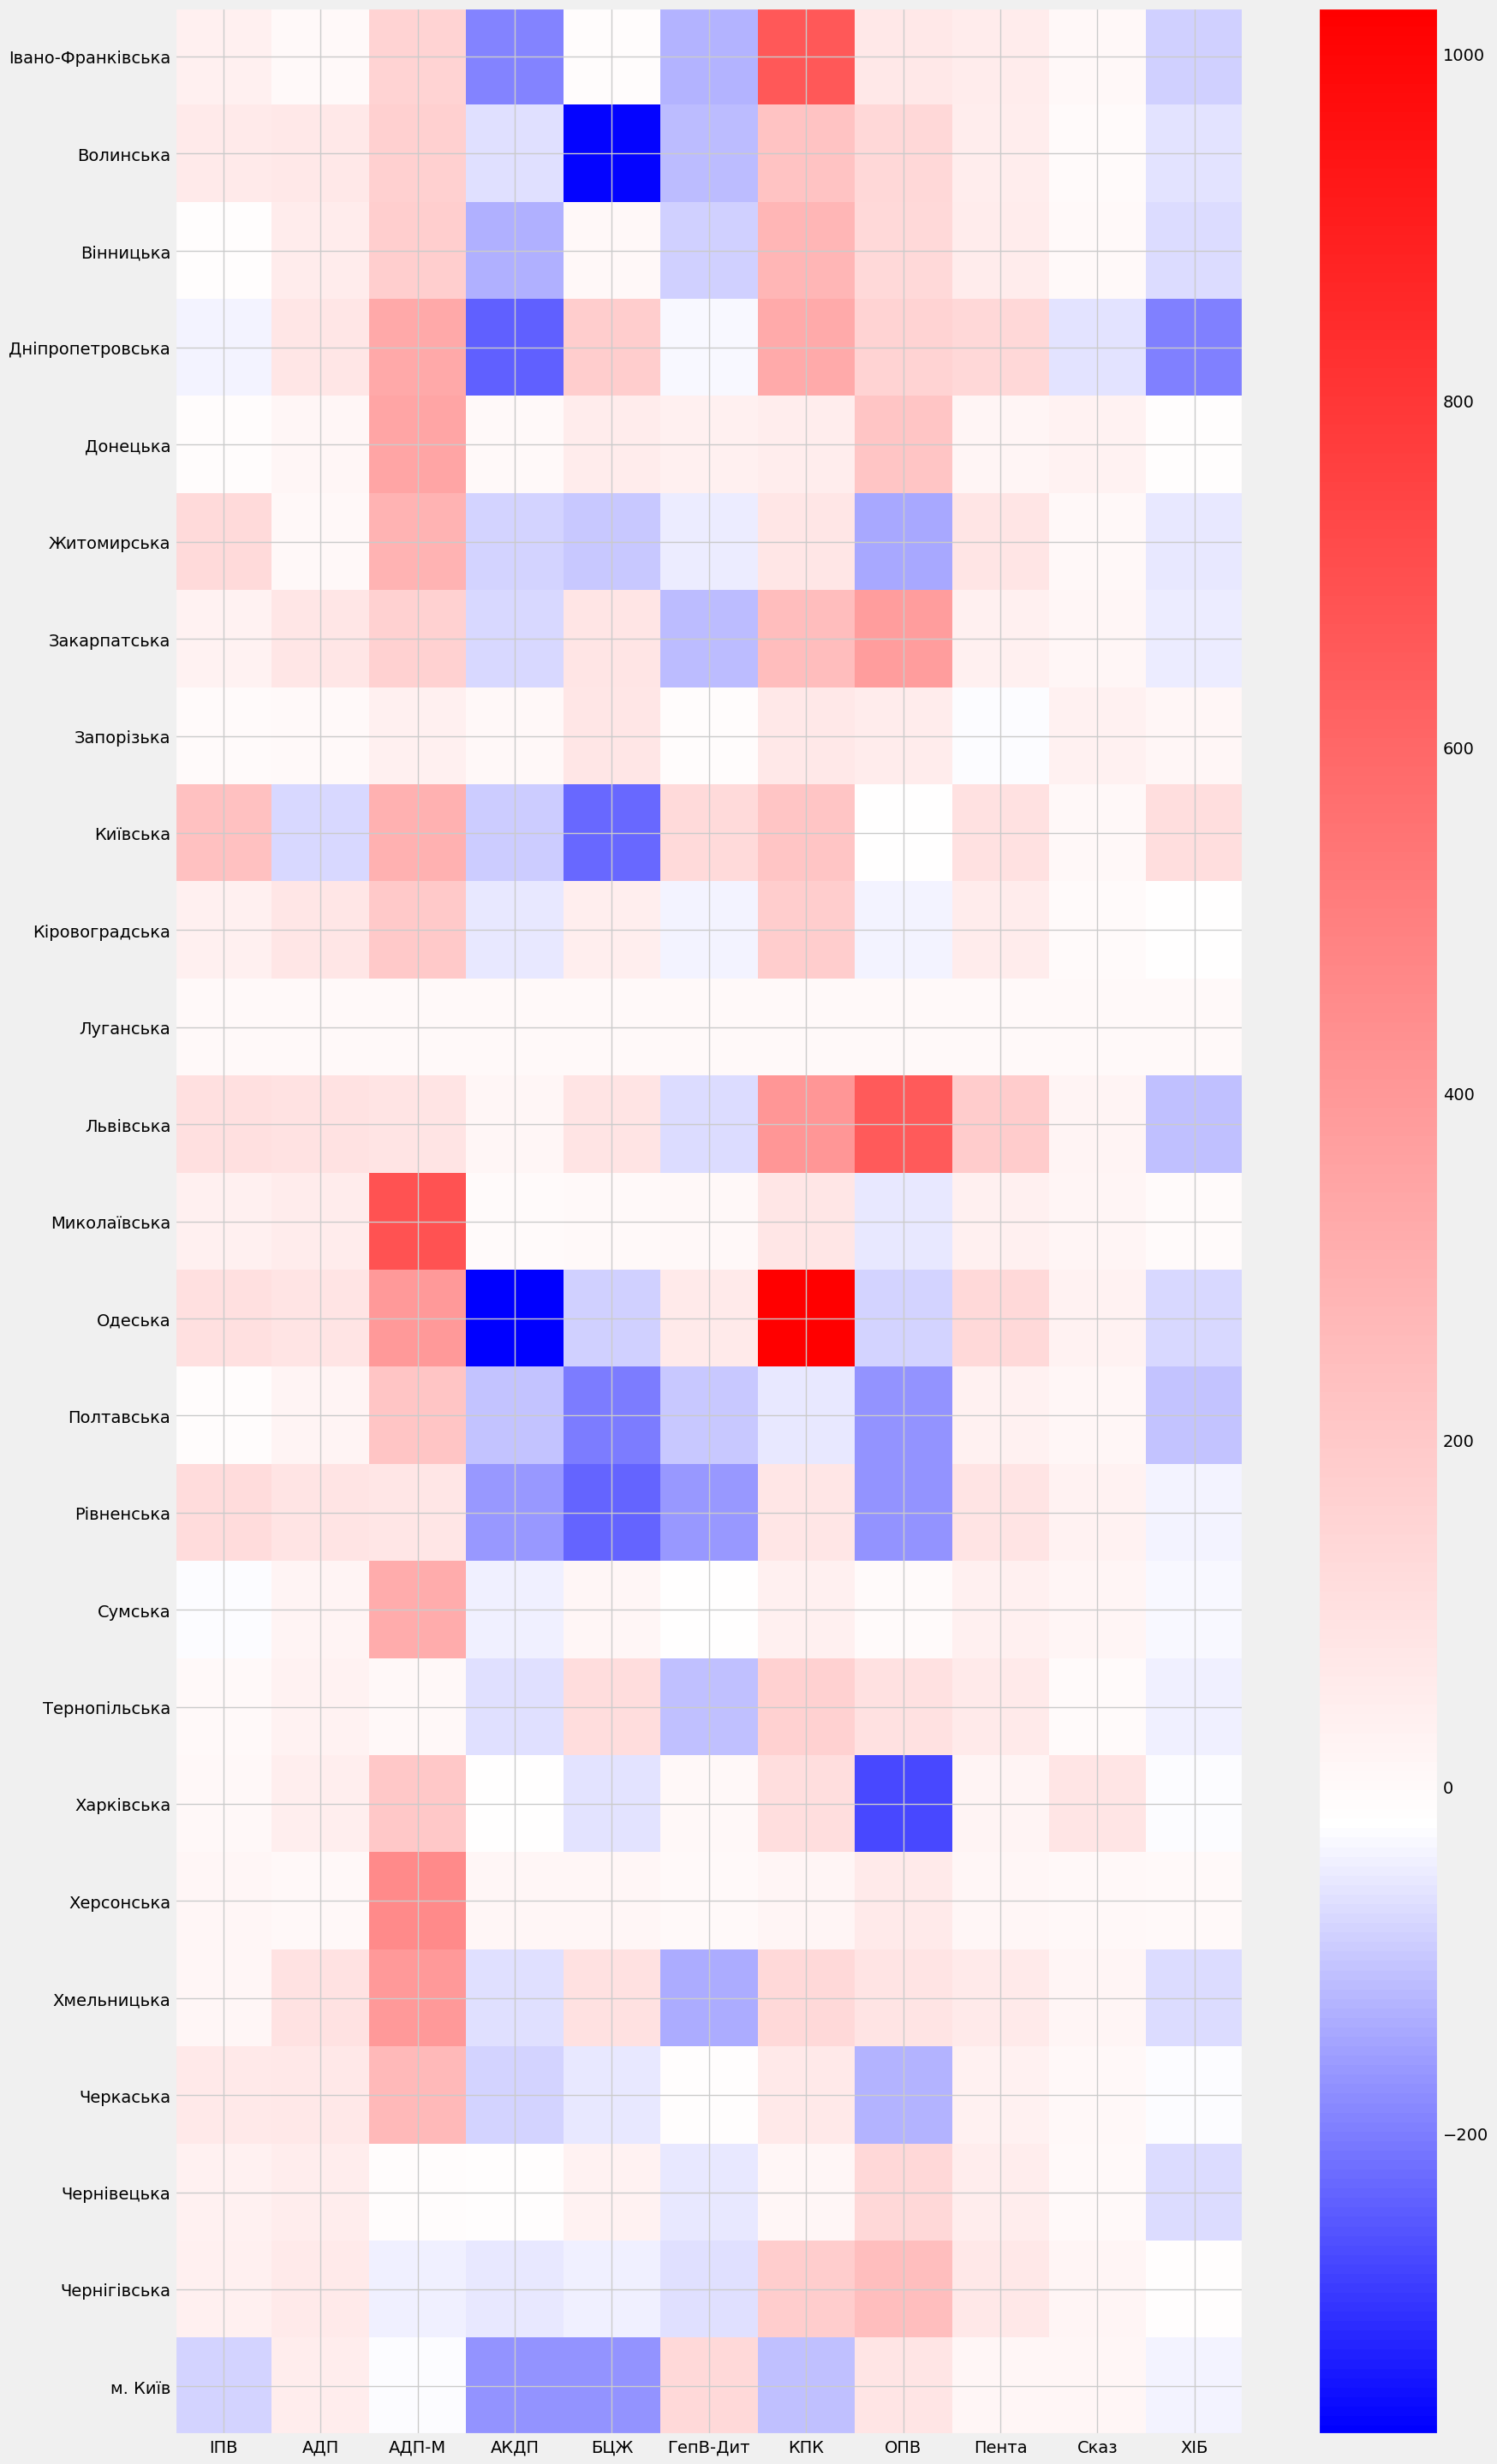

In [ ]:
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

plt.figure(figsize=(20, 35))

cmap = mcolors.LinearSegmentedColormap.from_list(
    "mycmap", [(0, "blue"), (0.25, "white"), (1, "red")]
)

# Assuming 'df' is your DataFrame
plt.imshow(mean_trends, cmap=cmap, interpolation='nearest')

plt.xticks(np.arange(len(mean_trends.columns)), mean_trends.columns)
plt.yticks(np.arange(len(mean_trends.index)), mean_trends.index)

# Show a colorbar
plt.colorbar()

# Show the plot
plt.show()